## Figure of Merit: Test Transient Metric with Starcount Information Included ##

** 2016-10-10 ** - WIC: attempted to meld Mike Lund's stellar density metric with Peter Yoachim's Transient metric. The aim is to produce a figure of merit by including starcount in the fraction detected at each point, then multiplying the fraction by the "number of stars" according to the Lund Starcounts from sims_maf_contrib (which I think is really the Juric et al. MW model).

The summary statistic of the resulting metric is then the figure of merit we seek.

So: import everything we need:

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt

In [3]:
# Import our locally-grown metric
import AsTransientMetric

/Users/clarkson/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [4]:
# import the other pieces to set up the transient metric test
import healpy as hp
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db

In [5]:
# Mike Lund's StarCount metric, without the index hardcoding
import StarCountStandalone

## Run the StarCount metric once to get the normalization factor ##

In [6]:
slicer = slicers.HealpixSlicer(nside=64)
summaryMetrics = [metrics.SumMetric()]

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [7]:
distNear=10.
distFar=150000.

In [8]:
metricCount = StarCountStandalone.AsCountMetric(D1=distNear, D2=distFar)
metricList = [metricCount]

In [9]:
# Set up to run on our db output. Note this will give different normfacs for the two
# db's because each covers a different area on the sky. Deal with that later!!
runName1092 = 'ops2_1092'
sqlconstraint = 'filter = "r"'
plotDict={'logScale':True}
bDict1092Count={}
for i,metric in enumerate(metricList):
    bDict1092Count[i] = metricBundles.MetricBundle(metric, slicer, sqlconstraint, 
                                          runName=runName1092, plotDict=plotDict, 
                                              summaryMetrics=summaryMetrics)
opsdb1092 = db.OpsimDatabase(runName1092 + '_sqlite.db')
outDir1092 = 'TestStarcount1092'
resultsDb1092 = db.ResultsDb(outDir=outDir1092)

Querying database with constraint filter = "r"
Found 544257 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with filter = "r" sqlconstraint now.
monopole: 116348  dipole: lon: -109.095, lat: -34.194, amp: 98640.4
Plotting complete.
Time spent on 1092 Starcount Only: 7.380e+01 seconds


Optimal bin calculation tried to make 497 bins, returning 200


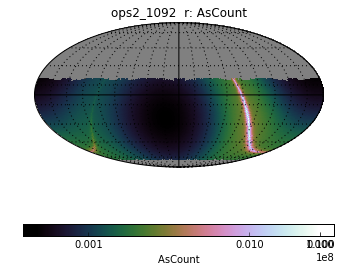

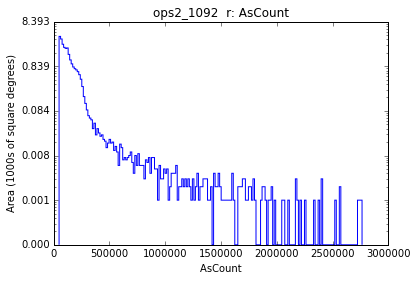

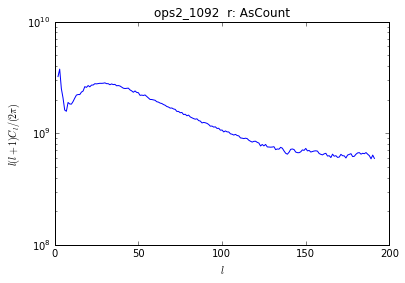

In [10]:
tStart = time.time()
bgroup1092 = metricBundles.MetricBundleGroup(bDict1092Count, opsdb1092, outDir=outDir1092, \
                                             resultsDb=resultsDb1092)
bgroup1092.runAll()
bgroup1092.plotAll(closefigs=False)
tPost1092 = time.time()
print "Time spent on 1092 Starcount Only: %.3e seconds" % (tPost1092 - tStart)

In [11]:
# OK good now add these up to get the normalization factor
bDict1092Count[0].computeSummaryStats(resultsDb=resultsDb1092)
print 'Sum for 1092: %.2e' % (bDict1092Count[0].summaryValues['Sum'])

Sum for 1092: 4.11e+09


In [12]:
# Now do the same, this time for 1189, without plotting (should be the same information)
runName1189 = 'enigma_1189'
sqlconstraint = 'filter = "r"'
plotDict={'logScale':True}
bDict1189Count={}
for i,metric in enumerate(metricList):
    bDict1189Count[i] = metricBundles.MetricBundle(metric, slicer, sqlconstraint, 
                                          runName=runName1189, plotDict=plotDict, 
                                              summaryMetrics=summaryMetrics)
opsdb1189 = db.OpsimDatabase(runName1189 + '_sqlite.db')
outDir1189 = 'TestStarcount1092'
resultsDb1189 = db.ResultsDb(outDir=outDir1189)

In [13]:
tStart = time.time()
bgroup1189 = metricBundles.MetricBundleGroup(bDict1189Count, opsdb1189, outDir=outDir1189, \
                                             resultsDb=resultsDb1189)
bgroup1189.runAll()
#bgroup1189.plotAll(closefigs=False)
tPost1189 = time.time()
print "Time spent on 1092 Starcount Only: %.3e seconds" % (tPost1189 - tStart)

Querying database with constraint filter = "r"
Found 544710 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Time spent on 1092 Starcount Only: 1.251e+02 seconds


In [14]:
bDict1189Count[0].computeSummaryStats(resultsDb=resultsDb1189)
print 'Sum for 1189: %.2e' % (bDict1189Count[0].summaryValues['Sum'])

Sum for 1189: 4.22e+09


### Starcount normalization factors, accounting for survey area ###

In [15]:
normStarcount1092 = 1.0/np.copy(bDict1092Count[0].summaryValues['Sum'])
normStarcount1189 = 1.0/np.copy(bDict1189Count[0].summaryValues['Sum'])

print "Normalizations: 1092: %.3e --- 1189: %.3e" % (normStarcount1092, normStarcount1189)

Normalizations: 1092: 2.431e-10 --- 1189: 2.370e-10


Now that we have these, we can try the Transient metric multiplied by the normalized starcounts. 

## Rough-guess parameters for the supernova model ##

In [16]:
peaks = {'uPeak':11, 'gPeak':9, 'rPeak':8, 'iPeak':7, 'zPeak':6,'yPeak':6}
colors = ['b','g','r','purple','y','magenta','k']
filterNames = ['u','g','r','i','z','y']

# Timing parameters of the outbursts. It's only really the rise that we care about for this FoM.
riseSlope = -2.4
declineSlope = 1.0
transDuration = 50.
peakTime = 20.

### Set up the slicer, including the SumMetric ###

In [17]:
slicer = slicers.HealpixSlicer(nside=64)
summaryMetrics = [metrics.SumMetric()]

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


### Set up the metric list for 1092 ###

In [18]:
nPhaseCheck=20
nPrePeak=4
metricList = []
metricRise = AsTransientMetric.AsTransientMetric(riseSlope=riseSlope, declineSlope=declineSlope, \
                               transDuration=transDuration, peakTime=peakTime, \
                               metricName='%i detections rise x StarCount, any filter' % (nPrePeak), \
                               nPrePeak=nPrePeak, 
                               nPhaseCheck=nPhaseCheck, \
                               distNear=distNear, distFar=distFar, normFac=normStarcount1092, \
                                                **peaks)

metricRiseTransient=metrics.TransientMetric(riseSlope=riseSlope, declineSlope=declineSlope, \
                               transDuration=transDuration, peakTime=peakTime, \
                               metricName='%i detections on rise, any filter' % (nPrePeak), \
                               nPrePeak=nPrePeak, 
                               nPhaseCheck=nPhaseCheck, \
                               **peaks)
metricList=[metricRise, metricRiseTransient]

In [19]:
plotDictLinear={'logScale':False}   # Doesn't seem to work, worryingly
plotDictLog = {'logScale':True}
runName1092 = 'ops2_1092'
sqlconstraint = ''
bDict1092={}
for i,metric in enumerate(metricList):
    bDict1092[i] = metricBundles.MetricBundle(metric, slicer, sqlconstraint, 
                                          runName=runName1092, summaryMetrics=summaryMetrics, 
                                             plotDict=plotDictLinear)   
opsdb1092 = db.OpsimDatabase(runName1092 + '_sqlite.db')
outDir1092 = 'Transients1092'
resultsDb1092 = db.ResultsDb(outDir=outDir1092)

Querying database with no constraint.
Found 2469027 visits
Running:  [0, 1]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with  sqlconstraint now.
monopole: 5.61886e-06  dipole: lon: -107.477, lat: -31.5133, amp: 4.54891e-06

Optimal bin calculation tried to make 785 bins, returning 200
Optimal bin calculation tried to make 226 bins, returning 200



monopole: 0.198093  dipole: lon: -6.43075, lat: 53.0882, amp: 0.00673709
Plotting complete.
Time spent on 1092: 1.125e+03 seconds


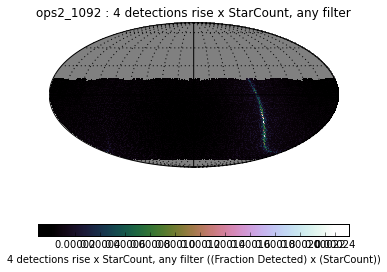

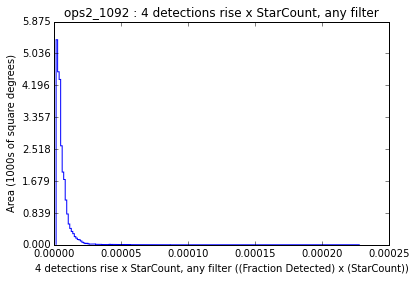

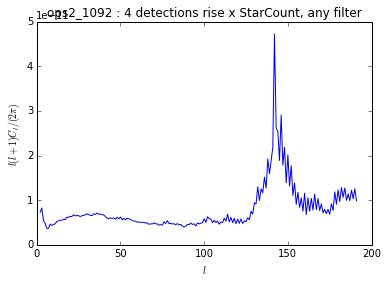

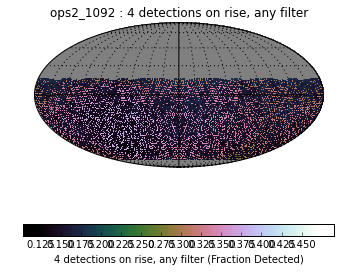

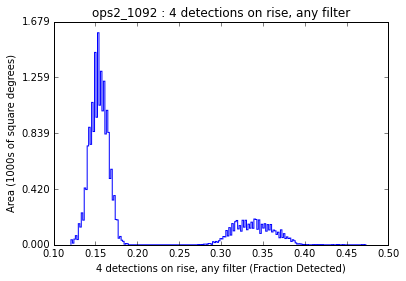

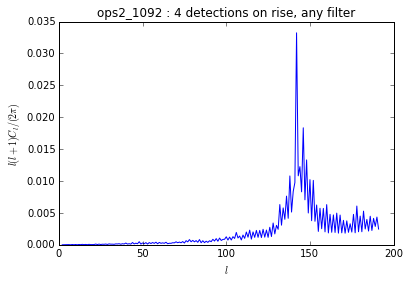

In [20]:
tStart = time.time()
bgroup1092 = metricBundles.MetricBundleGroup(bDict1092, opsdb1092, outDir=outDir1092, \
                                             resultsDb=resultsDb1092)
bgroup1092.runAll()
bgroup1092.plotAll(closefigs=False)  
tPost1092 = time.time()
print "Time spent on 1092: %.3e seconds" % (tPost1092 - tStart)

In [21]:
bDict1092[0].computeSummaryStats(resultsDb=resultsDb1092)
print 'Sum of combined metric for 1092: %.2e' % (bDict1092[0].summaryValues['Sum'])

Sum of combined metric for 1092: 1.96e-01


### Now do the same for 1189 ###

In [22]:
nPhaseCheck=20
nPrePeak=4
metricList = []
metricRise = AsTransientMetric.AsTransientMetric(riseSlope=riseSlope, declineSlope=declineSlope, \
                               transDuration=transDuration, peakTime=peakTime, \
                               metricName='%i detections rise x Starcount, any filter' % (nPrePeak), \
                               nPrePeak=nPrePeak, 
                               nPhaseCheck=nPhaseCheck, \
                               distNear=distNear, distFar=distFar, normFac=normStarcount1189, \
                                                **peaks)
metricRiseTransient=metrics.TransientMetric(riseSlope=riseSlope, declineSlope=declineSlope, \
                               transDuration=transDuration, peakTime=peakTime, \
                               metricName='%i detections on rise, any filter' % (nPrePeak), \
                               nPrePeak=nPrePeak, 
                               nPhaseCheck=nPhaseCheck, \
                               **peaks)
metricList=[metricRise, metricRiseTransient]

plotDictLinear={'logScale':False}   # Doesn't seem to work, worryingly
plotDictLog = {'logScale':True}
runName1189 = 'enigma_1189'
sqlconstraint = ''
bDict1189={}
for i,metric in enumerate(metricList):
    bDict1189[i] = metricBundles.MetricBundle(metric, slicer, sqlconstraint, 
                                          runName=runName1189, summaryMetrics=summaryMetrics, 
                                             plotDict=plotDictLinear)   
opsdb1189 = db.OpsimDatabase(runName1189 + '_sqlite.db')
outDir1189 = 'Transients1189'
resultsDb1189 = db.ResultsDb(outDir=outDir1189)

Querying database with no constraint.
Found 2469307 visits
Running:  [0, 1]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with  sqlconstraint now.
monopole: 4.79181e-06  dipole: lon: -131.795, lat: -30.3854, amp: 2.6338e-06
monopole: 0.172712  dipole: lon: 82.7228, lat: -79.3959, amp: 0.0345177
Plotting complete.
Time spent on 1092: 1.301e+04 seconds


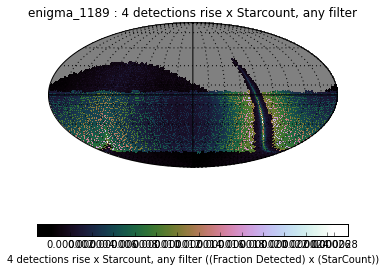

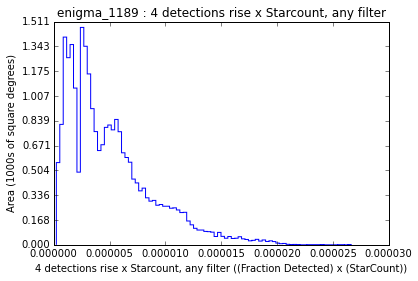

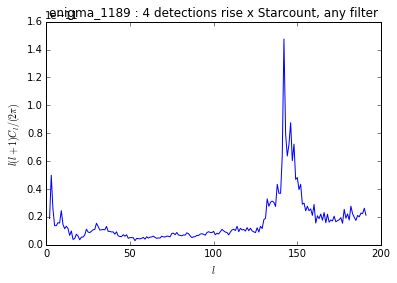

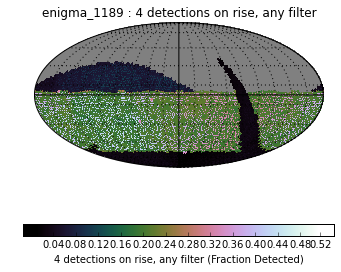

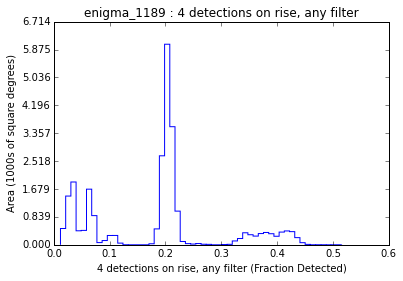

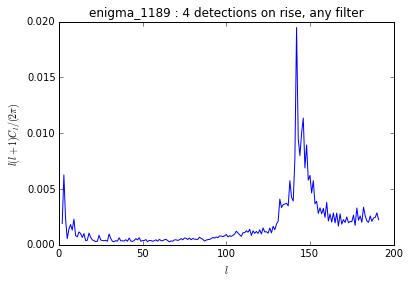

In [23]:
tStart = time.time()
bgroup1189 = metricBundles.MetricBundleGroup(bDict1189, opsdb1189, outDir=outDir1189, \
                                             resultsDb=resultsDb1189)
bgroup1189.runAll()
bgroup1189.plotAll(closefigs=False)  
tPost1189 = time.time()
print "Time spent on 1189: %.3e seconds" % (tPost1189 - tStart)

In [24]:
bDict1189[0].computeSummaryStats(resultsDb=resultsDb1189)
print 'Sum of combined metric for 1189: %.2e' % (bDict1189[0].summaryValues['Sum'])

Sum of combined metric for 1189: 1.59e-01


In [25]:
1.3e4/3.6e3

3.611111111111111